In [1]:
require 'torch'

os.execute('wget -c http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz')
os.execute('tar -xvf cifar-10-binary.tar.gz')
local function convertCifar10BinToTorchTensor(inputFnames, outputFname)
   local nSamples = 0
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      assert(nSamplesF == math.floor(nSamplesF), 'expecting numSamples to be an exact integer')
      nSamples = nSamples + nSamplesF
      m:close()
   end

   local label = torch.ByteTensor(nSamples)
   local data = torch.ByteTensor(nSamples, 3, 32, 32)

   local index = 1
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      m:seek(1)
      for j=1,nSamplesF do
         label[index] = m:readByte()
         local store = m:readByte(3072)
         data[index]:copy(torch.ByteTensor(store))
         index = index + 1
      end
      m:close()
   end

   local out = {}
   out.data = data
   out.label = label
   print(out)
   torch.save(outputFname, out)
end

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/data_batch_1.bin',
                                'cifar-10-batches-bin/data_batch_2.bin',
                                'cifar-10-batches-bin/data_batch_3.bin',
                                'cifar-10-batches-bin/data_batch_4.bin',
                                'cifar-10-batches-bin/data_batch_5.bin'},
   'cifar10-train.t7')

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/test_batch.bin'},
   'cifar10-test.t7')

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin


cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin


cifar-10-batches-bin/data_batch_4.bin


cifar-10-batches-bin/test_batch.bin


cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin


cifar-10-batches-bin/data_batch_2.bin


{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}


{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [2]:
require 'nn';
require 'paths'
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [3]:
trainset.label = trainset.label+1
testset.label = testset.label+1

In [4]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(testset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function testset:size() 
    return self.data:size(1) 
end

In [5]:
r = trainset.data[{ {}, {1}, {}, {}  }]*0.2989
g = trainset.data[{ {}, {2}, {}, {}  }]*0.5870
b = trainset.data[{ {}, {3}, {}, {}  }]*0.1140
trainset.data = r+g+b
r = testset.data[{ {}, {1}, {}, {}  }]*0.2989
g = testset.data[{ {}, {2}, {}, {}  }]*0.5870
b = testset.data[{ {}, {3}, {}, {}  }]*0.1140
testset.data = r+g+b

In [6]:
trainset.data = trainset.data/255
testset.data = testset.data/255

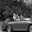

automobile	
2	


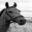

horse	
8	


In [7]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])
print(trainset.label[100])
itorch.image(testset.data[100]) -- display the 100-th image in dataset
print(classes[testset.label[100]])
print(testset.label[100])

In [8]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax(1)) 

In [9]:
criterion = nn.ClassNLLCriterion()

In [10]:
require 'cunn';
require 'cutorch';
cutorch.setDevice(2)
print(cutorch.getDevice())

2	


In [11]:
net = net:cuda()

In [12]:
criterion = criterion:cuda()

In [13]:
targets=trainset.label:long()
one_hot_train = torch.eye(10):index(1, targets)
--targets=testset.label:long()
--one_hot_test = torch.eye(10):index(1, targets)

In [14]:
trainset.data = trainset.data:cuda()
--trainset.label = one_hot_train:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()
testset.label = testset.label:cuda()

In [15]:
parameters, gradParameters = net:getParameters()

In [38]:
dl = require 'dataload'
optim = require 'optim';

train_loss={}
train_acc={}
test_loss={}
test_acc={}
function eval_train(epoch)
    local correct = 0
    local loss = 0
    local predictions = net:forward(trainset.data)
    local ll=criterion:forward(predictions, trainset.label)
    
    for i=1,10000 do
        local groundtruth = trainset.label[i]
        local prediction = predictions[i]
        -- loss = loss + ll[i]
        local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
        if groundtruth == indices[1] then
            correct = correct + 1
        end
    end
    --train_loss[epoch]=loss/10000
    train_loss[epoch]=ll
    train_acc[epoch]=correct/10000
    print('Train loss :' .. train_loss[epoch])
    print('Train Accuracy :' ,correct, 100*train_acc[epoch] .. ' % ')
end
function eval_test(epoch)
    local correct = 0
    local loss = 0
    local predictions = net:forward(testset.data)
    local ll=criterion:forward(predictions, testset.label)

    for i=1,10000 do
        local prediction = predictions[i]
        local groundtruth = testset.label[i]
        --loss = loss + ll[i]
        local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
        if groundtruth == indices[1] then
            correct = correct + 1
        end
    end
    --test_loss[epoch]=loss/10000
    test_loss[epoch]=ll
    test_acc[epoch]=correct/10000
    print('Test loss :' ..test_loss[epoch])
    print('Test Accuracy', correct, 100*test_acc[epoch] .. ' % ')
end

In [39]:

one_hot = torch.eye(10):index(1, targets)
dataloader = dl.TensorLoader(trainset.data, trainset.label)
i=0
batch_size=1000
epochs=100

-- Define SGD parameters.
sgd_params = {
    learningRate = 0.1,
    weightDecay = 0,
    momentum = 0.5
}
tstart=os.time()

for j=1,epochs do
    print("------ epoch - " ..j.. " ----- ")
    tot_loss=0
    for k, inputs, targets in dataloader:subiter(batch_size,50000) do
        -- Define a closure that computes the loss and dloss/dx.
        feval = function()
            -- reset gradients
            gradParameters:zero()
            output=net:forward(inputs)
            loss=criterion:forward(output, targets)
            gradients = criterion:backward(output, targets)
            net:backward(inputs, gradients)
            return loss, gradParameters
        end
        _,local_loss = optim.sgd(feval, parameters, sgd_params)
        ---tot_loss = tot_loss + local_loss[1]
    end
    eval_train(j)
    eval_test(j)
    ---print("------- loss - " ..(tot_loss/50).. " ------ ")
end

tend=os.time()
print("------ Time taken :",os.difftime (tend , tstart))

------ epoch - 1 ----- 	


Train loss :2.1080279350281	
Train Accuracy :	2300	23 % 	


Test loss :2.107449054718	
Test Accuracy	2320	23.2 % 	
------ epoch - 2 ----- 	


Train loss :2.061977148056	
Train Accuracy :	2510	25.1 % 	


Test loss :2.0610885620117	
Test Accuracy	2500	25 % 	
------ epoch - 3 ----- 	


Train loss :2.0211532115936	
Train Accuracy :	2739	27.39 % 	


Test loss :2.0215485095978	
Test Accuracy	2726	27.26 % 	
------ epoch - 4 ----- 	


Train loss :1.9546384811401	
Train Accuracy :	3016	30.16 % 	


Test loss :1.9542533159256	
Test Accuracy	3000	30 % 	
------ epoch - 5 ----- 	


Train loss :1.8975735902786	
Train Accuracy :	3320	33.2 % 	


Test loss :1.8962111473083	
Test Accuracy	3268	32.68 % 	
------ epoch - 6 ----- 	


Train loss :1.8593620061874	
Train Accuracy :	3471	34.71 % 	


Test loss :1.8593300580978	
Test Accuracy	3425	34.25 % 	
------ epoch - 7 ----- 	


Train loss :1.8224713802338	
Train Accuracy :	3582	35.82 % 	


Test loss :1.8244668245316	
Test Accuracy	3525	35.25 % 	
------ epoch - 8 ----- 	


Train loss :1.7751950025558	
Train Accuracy :	3744	37.44 % 	


Test loss :1.7804554700851	
Test Accuracy	3620	36.2 % 	
------ epoch - 9 ----- 	


Train loss :1.7978239059448	
Train Accuracy :	3673	36.73 % 	


Test loss :1.8030467033386	
Test Accuracy	3502	35.02 % 	
------ epoch - 10 ----- 	


Train loss :1.7105070352554	
Train Accuracy :	3946	39.46 % 	


Test loss :1.7176856994629	
Test Accuracy	3862	38.62 % 	
------ epoch - 11 ----- 	


Train loss :1.7013514041901	
Train Accuracy :	3955	39.55 % 	


Test loss :1.7117708921432	
Test Accuracy	3865	38.65 % 	
------ epoch - 12 ----- 	


Train loss :1.6602512598038	
Train Accuracy :	4120	41.2 % 	


Test loss :1.6736392974854	
Test Accuracy	4038	40.38 % 	
------ epoch - 13 ----- 	


Train loss :1.6346927881241	
Train Accuracy :	4238	42.38 % 	


Test loss :1.6509138345718	
Test Accuracy	4125	41.25 % 	
------ epoch - 14 ----- 	


Train loss :1.6209050416946	
Train Accuracy :	4266	42.66 % 	


Test loss :1.6404374837875	
Test Accuracy	4130	41.3 % 	
------ epoch - 15 ----- 	


Train loss :1.6074376106262	
Train Accuracy :	4318	43.18 % 	


Test loss :1.6299139261246	
Test Accuracy	4193	41.93 % 	
------ epoch - 16 ----- 	


Train loss :1.7114635705948	
Train Accuracy :	3931	39.31 % 	


Test loss :1.7337417602539	
Test Accuracy	3870	38.7 % 	
------ epoch - 17 ----- 	


Train loss :1.565745472908	
Train Accuracy :	4459	44.59 % 	


Test loss :1.5952477455139	
Test Accuracy	4307	43.07 % 	
------ epoch - 18 ----- 	


Train loss :1.5633101463318	
Train Accuracy :	4487	44.87 % 	


Test loss :1.5952149629593	
Test Accuracy	4309	43.09 % 	
------ epoch - 19 ----- 	


Train loss :1.5674134492874	
Train Accuracy :	4413	44.13 % 	


Test loss :1.601971745491	
Test Accuracy	

4276	42.76 % 	
------ epoch - 20 ----- 	


Train loss :1.6265230178833	
Train Accuracy :	4271	42.71 % 	


Test loss :1.6609958410263	
Test Accuracy	4185	41.85 % 	
------ epoch - 21 ----- 	


Train loss :1.4869416952133	
Train Accuracy :	4815	48.15 % 	


Test loss :1.5290632247925	
Test Accuracy	4607	46.07 % 	
------ epoch - 22 ----- 	


Train loss :1.4871245622635	
Train Accuracy :	4748	47.48 % 	


Test loss :1.5331612825394	
Test Accuracy	

4608	46.08 % 	
------ epoch - 23 ----- 	


Train loss :1.4719285964966	
Train Accuracy :	4796	47.96 % 	


Test loss :1.5229340791702	
Test Accuracy	4643	46.43 % 	
------ epoch - 24 ----- 	


Train loss :1.4372947216034	
Train Accuracy :	4959	49.59 % 	


Test loss :1.4942018985748	
Test Accuracy	4719	47.19 % 	
------ epoch - 25 ----- 	


Train loss :1.4904774427414	
Train Accuracy :	4772	47.72 % 	


Test loss :1.5483973026276	
Test Accuracy	4555	45.55 % 	


------ epoch - 26 ----- 	


Train loss :1.3988127708435	
Train Accuracy :	5139	51.39 % 	


Test loss :1.4653655290604	
Test Accuracy	4818	48.18 % 	
------ epoch - 27 ----- 	


Train loss :1.3990684747696	
Train Accuracy :	5112	51.12 % 	


Test loss :1.4688755273819	
Test Accuracy	4830	48.3 % 	
------ epoch - 28 ----- 	


Train loss :1.4024914503098	
Train Accuracy :	5095	50.95 % 	


Test loss :1.4760383367538	
Test Accuracy	4820	48.2 % 	
------ epoch - 29 ----- 	


Train loss :1.4272475242615	
Train Accuracy :	5028	50.28 % 	


Test loss :1.5036183595657	
Test Accuracy	4701	47.01 % 	
------ epoch - 30 ----- 	


Train loss :1.4365051984787	
Train Accuracy :	4992	49.92 % 	


Test loss :1.5158379077911	
Test Accuracy	4695	46.95 % 	
------ epoch - 31 ----- 	


Train loss :1.4544851779938	
Train Accuracy :	4947	49.47 % 	


Test loss :1.5386847257614	
Test Accuracy	4669	46.69 % 	
------ epoch - 32 ----- 	


Train loss :1.4179475307465	
Train Accuracy :	5044	50.44 % 	


Test loss :1.5069355964661	
Test Accuracy	4675	46.75 % 	
------ epoch - 33 ----- 	


Train loss :1.4278298616409	
Train Accuracy :	5018	50.18 % 	


Test loss :1.5208743810654	
Test Accuracy	4726	47.26 % 	
------ epoch - 34 ----- 	


Train loss :1.4217745065689	
Train Accuracy :	5094	50.94 % 	


Test loss :1.519219994545	
Test Accuracy	4759	47.59 % 	
------ epoch - 35 ----- 	


Train loss :1.403506398201	
Train Accuracy :	5058	50.58 % 	


Test loss :1.5032780170441	
Test Accuracy	4696	46.96 % 	
------ epoch - 36 ----- 	


Train loss :1.3596841096878	
Train Accuracy :	5270	52.7 % 	


Test loss :1.4678000211716	
Test Accuracy	4875	48.75 % 	
------ epoch - 37 ----- 	


Train loss :1.3628442287445	
Train Accuracy :	5241	52.41 % 	


Test loss :1.4759151935577	
Test Accuracy	4834	48.34 % 	
------ epoch - 38 ----- 	


Train loss :1.3352122306824	
Train Accuracy :	5394	53.94 % 	


Test loss :1.456632733345	
Test Accuracy	4941	49.41 % 	
------ epoch - 39 ----- 	


Train loss :1.2967214584351	
Train Accuracy :	5481	54.81 % 	


Test loss :1.4242564439774	
Test Accuracy	5023	50.23 % 	
------ epoch - 40 ----- 	


Train loss :1.3111579418182	
Train Accuracy :	5474	54.74 % 	


Test loss :1.4453673362732	
Test Accuracy	4984	49.84 % 	
------ epoch - 41 ----- 	


Train loss :1.2823483943939	
Train Accuracy :	5532	55.32 % 	


Test loss :1.4187451601028	
Test Accuracy	5079	50.79 % 	
------ epoch - 42 ----- 	


Train loss :1.3570747375488	
Train Accuracy :	5205	52.05 % 	


Test loss :1.4957085847855	
Test Accuracy	4845	48.45 % 	
------ epoch - 43 ----- 	


Train loss :1.4192926883698	


Train Accuracy :	5135	51.35 % 	


Test loss :1.562136888504	
Test Accuracy	4772	47.72 % 	
------ epoch - 44 ----- 	


Train loss :1.2140390872955	
Train Accuracy :	5824	58.24 % 	


Test loss :1.372753739357	
Test Accuracy	5252	52.52 % 	
------ epoch - 45 ----- 	


Train loss :1.2501375675201	
Train Accuracy :	5642	56.42 % 	


Test loss :1.4095002412796	
Test Accuracy	5123	51.23 % 	
------ epoch - 46 ----- 	


Train loss :1.2307957410812	
Train Accuracy :	5730	57.3 % 	


Test loss :1.394920706749	
Test Accuracy	5145	51.45 % 	
------ epoch - 47 ----- 	


Train loss :1.3220932483673	
Train Accuracy :	5471	54.71 % 	


Test loss :1.4905593395233	
Test Accuracy	4963	49.63 % 	
------ epoch - 48 ----- 	


Train loss :1.1779927015305	
Train Accuracy :	5929	59.29 % 	


Test loss :1.3606818914413	
Test Accuracy	5327	53.27 % 	
------ epoch - 49 ----- 	


Train loss :1.1656579971313	
Train Accuracy :	5998	59.98 % 	


Test loss :1.3475488424301	
Test Accuracy	5375	53.75 % 	
------ epoch - 50 ----- 	


Train loss :1.1634619235992	
Train Accuracy :	6021	60.21 % 	


Test loss :1.3557733297348	
Test Accuracy	5354	53.54 % 	
------ epoch - 51 ----- 	


Train loss :1.140897154808	
Train Accuracy :	6098	60.98 % 	


Test loss :1.3363176584244	
Test Accuracy	5425	54.25 % 	
------ epoch - 52 ----- 	


Train loss :1.1409751176834	
Train Accuracy :	6122	61.22 % 	


Test loss :1.3487908840179	
Test Accuracy	5390	53.9 % 	
------ epoch - 53 ----- 	


Train loss :1.1894446611404	
Train Accuracy :	5906	59.06 % 	


Test loss :1.3878583908081	
Test Accuracy	5259	52.59 % 	
------ epoch - 54 ----- 	


Train loss :1.1436355113983	
Train Accuracy :	6049	60.49 % 	


Test loss :1.3533028364182	
Test Accuracy	5402	54.02 % 	
------ epoch - 55 ----- 	


Train loss :1.0982567071915	
Train Accuracy :	6227	62.27 % 	


Test loss :1.3249977827072	
Test Accuracy	5456	54.56 % 	
------ epoch - 56 ----- 	


Train loss :1.1071215867996	
Train Accuracy :	6211	62.11 % 	


Test loss :1.3332127332687	
Test Accuracy	5434	54.34 % 	
------ epoch - 57 ----- 	


Train loss :1.1008266210556	
Train Accuracy :	6249	62.49 % 	


Test loss :1.3325884342194	
Test Accuracy	5471	54.71 % 	
------ epoch - 58 ----- 	


Train loss :1.1534266471863	
Train Accuracy :	6019	60.19 % 	


Test loss :1.3804793357849	
Test Accuracy	5296	52.96 % 	
------ epoch - 59 ----- 	


Train loss :1.0871057510376	
Train Accuracy :	6282	62.82 % 	


Test loss :1.3297307491302	
Test Accuracy	5511	55.11 % 	
------ epoch - 60 ----- 	


Train loss :1.1299967765808	
Train Accuracy :	6106	61.06 % 	


Test loss :1.383015871048	
Test Accuracy	5355	53.55 % 	
------ epoch - 61 ----- 	


Train loss :1.0818886756897	
Train Accuracy :	6279	62.79 % 	


Test loss :1.3393703699112	
Test Accuracy	5483	54.83 % 	
------ epoch - 62 ----- 	


Train loss :1.0583213567734	
Train Accuracy :	6392	63.92 % 	


Test loss :1.3283191919327	
Test Accuracy	5540	55.4 % 	
------ epoch - 63 ----- 	


Train loss :1.0492142438889	
Train Accuracy :	6414	64.14 % 	


Test loss :1.3242617845535	
Test Accuracy	5542	55.42 % 	
------ epoch - 64 ----- 	


Train loss :1.0744645595551	
Train Accuracy :	6330	63.3 % 	


Test loss :1.3462529182434	
Test Accuracy	5472	54.72 % 	
------ epoch - 65 ----- 	


Train loss :1.0537128448486	
Train Accuracy :	6425	64.25 % 	


Test loss :1.3336375951767	
Test Accuracy	5526	55.26 % 	
------ epoch - 66 ----- 	


Train loss :1.022360086441	
Train Accuracy :	6558	65.58 % 	


Test loss :1.3150609731674	
Test Accuracy	

5599	55.99 % 	
------ epoch - 67 ----- 	


Train loss :1.011426448822	
Train Accuracy :	

6589	65.89 % 	


Test loss :1.3114167451859	
Test Accuracy	5611	56.11 % 	
------ epoch - 68 ----- 	


Train loss :1.017419219017	
Train Accuracy :	6519	65.19 % 	


Test loss :1.3222913742065	
Test Accuracy	5599	55.99 % 	
------ epoch - 69 ----- 	


Train loss :0.99830365180969	
Train Accuracy :	6595	65.95 % 	


Test loss :1.3118181228638	
Test Accuracy	5643	56.43 % 	
------ epoch - 70 ----- 	


Train loss :1.0093340873718	
Train Accuracy :	6586	65.86 % 	


Test loss :1.3281899690628	


Test Accuracy	5606	56.06 % 	
------ epoch - 71 ----- 	


Train loss :1.0358601808548	
Train Accuracy :	6436	64.36 % 	


Test loss :1.3473600149155	
Test Accuracy	5504	55.04 % 	
------ epoch - 72 ----- 	


Train loss :1.0052007436752	
Train Accuracy :	6580	65.8 % 	


Test loss :1.3346801996231	
Test Accuracy	5590	55.9 % 	
------ epoch - 73 ----- 	


Train loss :1.0294107198715	
Train Accuracy :	6439	64.39 % 	


Test loss :1.3679474592209	
Test Accuracy	5472	54.72 % 	
------ epoch - 74 ----- 	


Train loss :0.9541802406311	
Train Accuracy :	6761	67.61 % 	


Test loss :1.3104202747345	
Test Accuracy	5651	56.51 % 	
------ epoch - 75 ----- 	


Train loss :0.97839915752411	
Train Accuracy :	6648	66.48 % 	


Test loss :1.3383224010468	
Test Accuracy	5597	55.97 % 	
------ epoch - 76 ----- 	


Train loss :0.99180364608765	
Train Accuracy :	6608	66.08 % 	


Test loss :1.3635976314545	
Test Accuracy	

5569	55.69 % 	
------ epoch - 77 ----- 	


Train loss :1.0202234983444	
Train Accuracy :	6457	64.57 % 	


Test loss :1.3768206834793	
Test Accuracy	5446	54.46 % 	
------ epoch - 78 ----- 	


Train loss :1.0323392152786	
Train Accuracy :	6435	64.35 % 	


Test loss :1.4075692892075	
Test Accuracy	5403	54.03 % 	
------ epoch - 79 ----- 	


Train loss :0.95831906795502	
Train Accuracy :	

6701	67.01 % 	


Test loss :1.3547673225403	


Test Accuracy	5615	56.15 % 	
------ epoch - 80 ----- 	


Train loss :0.98849296569824	
Train Accuracy :	6600	66 % 	


Test loss :1.3851588964462	
Test Accuracy	5534	55.34 % 	
------ epoch - 81 ----- 	


Train loss :1.0290036201477	
Train Accuracy :	6461	64.61 % 	


Test loss :1.4340944290161	
Test Accuracy	5410	54.1 % 	
------ epoch - 82 ----- 	


Train loss :1.026350736618	
Train Accuracy :	6422	64.22 % 	


Test loss :1.4181478023529	
Test Accuracy	5350	53.5 % 	
------ epoch - 83 ----- 	


Train loss :0.99596530199051	
Train Accuracy :	6545	65.45 % 	


Test loss :1.412057518959	
Test Accuracy	5451	54.51 % 	
------ epoch - 84 ----- 	


Train loss :0.99873512983322	
Train Accuracy :	6531	65.31 % 	


Test loss :1.4065606594086	
Test Accuracy	5403	54.03 % 	
------ epoch - 85 ----- 	


Train loss :0.97606241703033	
Train Accuracy :	6609	66.09 % 	


Test loss :1.4023289680481	
Test Accuracy	5467	54.67 % 	
------ epoch - 86 ----- 	


Train loss :0.92775446176529	
Train Accuracy :	6770	67.7 % 	


Test loss :1.3708666563034	
Test Accuracy	5612	56.12 % 	
------ epoch - 87 ----- 	


Train loss :0.9045478105545	
Train Accuracy :	6842	68.42 % 	


Test loss :1.3597695827484	
Test Accuracy	5671	56.71 % 	
------ epoch - 88 ----- 	


Train loss :0.93443548679352	
Train Accuracy :	6761	67.61 % 	


Test loss :1.3970283269882	
Test Accuracy	5536	55.36 % 	
------ epoch - 89 ----- 	


Train loss :0.9099263548851	
Train Accuracy :	6816	68.16 % 	

Test loss :1.386661529541	
Test Accuracy	5612	56.12 % 	
------ epoch - 90 ----- 	


Train loss :0.92658311128616	
Train Accuracy :	6738	67.38 % 	


Test loss :1.4041332006454	
Test Accuracy	5522	55.22 % 	
------ epoch - 91 ----- 	


Train loss :0.89911437034607	
Train Accuracy :	6857	68.57 % 	


Test loss :1.392795920372	
Test Accuracy	5616	56.16 % 	


------ epoch - 92 ----- 	


Train loss :0.86170142889023	
Train Accuracy :	7005	70.05 % 	


Test loss :1.3708385229111	
Test Accuracy	5684	56.84 % 	
------ epoch - 93 ----- 	


Train loss :0.87331318855286	
Train Accuracy :	6966	69.66 % 	


Test loss :1.3924006223679	
Test Accuracy	5640	56.4 % 	
------ epoch - 94 ----- 	


Train loss :0.90175473690033	
Train Accuracy :	6836	68.36 % 	


Test loss :1.415115237236	
Test Accuracy	5580	55.8 % 	
------ epoch - 95 ----- 	


Train loss :0.91830593347549	
Train Accuracy :	6795	67.95 % 	


Test loss :1.4509551525116	
Test Accuracy	5533	55.33 % 	
------ epoch - 96 ----- 	


Train loss :0.87892329692841	
Train Accuracy :	6888	68.88 % 	


Test loss :1.4317035675049	
Test Accuracy	5590	55.9 % 	
------ epoch - 97 ----- 	


Train loss :0.8554989695549	
Train Accuracy :	6994	69.94 % 	


Test loss :1.4188206195831	
Test Accuracy	5624	56.24 % 	
------ epoch - 98 ----- 	


Train loss :0.91047525405884	
Train Accuracy :	6802	68.02 % 	


Test loss :1.4811009168625	
Test Accuracy	5550	55.5 % 	
------ epoch - 99 ----- 	


Train loss :0.83866757154465	
Train Accuracy :	7080	70.8 % 	


Test loss :1.4240040779114	
Test Accuracy	5660	56.6 % 	
------ epoch - 100 ----- 	


Train loss :0.82278138399124	
Train Accuracy :	7119	71.19 % 	


Test loss :1.406568646431	
Test Accuracy	5679	56.79 % 	
------ Time taken :	760	


In [45]:
luarocks install json

[string "luarocks install json..."]:1: '=' expected near 'install': 

In [46]:
local Json = require("json")

-- Function to save a table.&nbsp; Since game settings need to be saved from session to session, we will
-- use the Documents Directory
function saveJSON(t, filename)
    local path = system.pathForFile( filename, system.DocumentsDirectory)
    local file = io.open(path, "w")

    if file then
        local contents = Json.encode(t)
        file:write( contents )
        io.close( file )
        return true
    else
        return false
    end
end

{
  1 : 2.1080279350281
  2 : 2.061977148056
  3 : 2.0211532115936
  4 : 1.9546384811401
  5 : 1.8975735902786
  6 : 1.8593620061874
  7 : 1.8224713802338
  8 : 1.7751950025558
  9 : 1.7978239059448
  10 : 1.7105070352554
  11 : 1.7013514041901
  12 : 1.6602512598038
  13 : 1.6346927881241
  14 : 1.6209050416946
  15 : 1.6074376106262
  16 : 1.7114635705948
  17 : 1.565745472908
  18 : 1.5633101463318
  19 : 1.5674134492874
  20 : 1.6265230178833
  21 : 1.4869416952133
  22 : 1.4871245622635
  23 : 1.4719285964966
  24 : 1.4372947216034
  25 : 1.4904774427414
  26 : 1.3988127708435
  27 : 1.3990684747696
  28 : 1.4024914503098
  29 : 1.4272475242615
  30 : 1.4365051984787
  31 : 1.4544851779938
  32 : 1.4179475307465
  33 : 1.4278298616409
  34 : 1.4217745065689
  35 : 1.403506398201
  36 : 1.3596841096878
  37 : 1.3628442287445
  38 : 1.3352122306824
  39 : 1.2967214584351
  40 : 1.3111579418182
  41 : 1.2823483943939
  42 : 1.3570747375488
  43 : 1.4192926883698
  44 : 1.214039087295

In [48]:
saveJSON(train_acc, 'train_acc.json')
saveJSON(test_acc, 'test_acc.json')
saveJSON(train_loss, 'train_loss.json')
saveJSON(test_loss, 'test_loss.json')

[string "..."]:2: attempt to call global 'saveJSON' (a nil value)
stack traceback:
	[string "..."]:2: in main chunk
	[C]: in function 'xpcall'
	/usr/local/torch/install/share/lua/5.1/itorch/main.lua:210: in function </usr/local/torch/install/share/lua/5.1/itorch/main.lua:174>
	/usr/local/torch/install/share/lua/5.1/lzmq/poller.lua:80: in function 'poll'
	/usr/local/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/usr/local/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/usr/local/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/usr/local/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [28]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	54.6 %	
automobile	85.8 %	
bird	0 %	
cat	8.9 %	
deer	0 %	
dog	50.7 %	
frog	0 %	
horse	32.7 %	
ship	27.3 %	
truck	34.1 %	
